In [136]:
# imports
import numpy as np
import torch
import torch.nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

# local imports
from models import SimpleModel, GAN

# Part 1

In this part, we are going to make a very simple example of a GAN.

The input will be a 1D function as described
[here](https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-1-dimensional-function-from-scratch-in-keras/).


First, we make the function

In [137]:
def real_function(x):
    f0 = 2.0
    return np.sin(f0 * np.pi * x)


Then we sample it, and plot it

In [137]:
# todo

Define the model(s):

A simple fully connected model with 1 hidden layer

The task is to do binary classification; yes or no, whether the sample was real.

Setup data generators

In [139]:
# generate n real samples with class labels
def generate_real_samples(n):
    # generate inputs in [-0.5, 0.5]
    x1 = 2 * np.random.rand(n) - 1
    # generate outputs X^2
    x2 = real_function(x1)
    # stack arrays
    x1 = x1.reshape(n, 1)
    x2 = x2.reshape(n, 1)
    x = np.hstack((x1, x2)).astype(float)
    # generate class labels
    y = np.ones((n, 1), dtype=float)
    return torch.from_numpy(x).float(), torch.from_numpy(y).float()


# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
    # generate points in the latent space
    x_input = np.random.randn(latent_dim * n)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n, latent_dim)

    return torch.from_numpy(x_input).float()


# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g, latent_dim, n):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n).float()
    # predict outputs
    x = g.forward(x_input).float()
    # create class labels
    y = np.zeros((n, 1), dtype=float)
    y = torch.from_numpy(y).float()
    return x, y

# Summarice the performance,
def summarize_performance(epoch, g, d, latent_dim, n=100):
    # prepare real and fake samples
    x_real, y_real = generate_real_samples(n)
    x_fake, y_fake = generate_fake_samples(g, latent_dim, n)
    # evaluate discriminator on fake examples
    with torch.no_grad():
        y_mreal = d.forward(x_real).reshape(-1)
        y_mfake = d.forward(x_fake).reshape(-1)
    acc_real = 0.0
    acc_fake = 0.0
    for f, r, mf, mr in zip(y_fake, y_real, y_mfake, y_mreal):
        acc_real += 1 if r > .5 and mr > .5 or r < .5 and mr < .5 else 0
        acc_fake += 1 if f > .5 and mf > .5 or f < .5 and mf < .5 else 0
    acc_real /= len(y_fake)
    acc_fake /= len(y_fake)

    # scatter plot real and fake data points
    plt.figure()
    plt.scatter(x_real[:, 0].detach().numpy(), x_real[:, 1].detach().numpy(), color='red')
    plt.scatter(x_fake[:, 0].detach().numpy(), x_fake[:, 1].detach().numpy(), color='blue')
    plt.scatter(x_real[y_mreal[:] > .5, 0].detach().numpy(), x_real[y_mreal[:] > .5, 1].detach().numpy(), color='green')
    plt.scatter(x_fake[y_mfake < .5, 0].detach().numpy(), x_fake[y_mfake < .5, 1].detach().numpy(), color='yellow')
    plt.legend(['real', 'fake', 'hits_real', 'hits_fake'])
    fig.suptitle(' '.join([str(x) for x in [epoch, acc_real, acc_fake]]))
    plt.show()


Train the GAN

In [140]:
n_data_per_epoch = 1000
batchsize = 128
n_epochs = 100
n_batches = n_data_per_epoch // batchsize


def train_batch(X, y, model, optimizer, loss_function=torch.nn.BCELoss):
    optimizer.zero_grad()
    X_model = model(X)
    loss = loss_function()(X_model, y)
    loss.backward()
    optimizer.step()

    return model, optimizer, loss


def train(generator, discriminator, gan_model, latent_dim, n_epochs=10000, n_batch=128, n_eval=2000):
    optimizer_discriminator = torch.optim.Adam(discriminator.parameters())
    optimizer_generator = torch.optim.Adam(generator.parameters())
    # determine half the size of one batch, for updating the discriminator
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # prepare real samples
        x_real, y_real = generate_real_samples(half_batch)
        # prepare fake examples
        x_fake, y_fake = generate_fake_samples(generator, latent_dim, half_batch)
        # train discriminator
        discriminator, optimizer_discriminator, loss_real = train_batch(x_real,
                                                                        y_real,
                                                                        discriminator,
                                                                        optimizer_discriminator)
        discriminator, optimizer_discriminator, loss_fake = train_batch(x_fake,
                                                                        y_fake,
                                                                        discriminator,
                                                                        optimizer_discriminator)
        # prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = torch.ones((n_batch, 1)).float()
        # train the generator via the discriminator's error
        gan_model, optimizer_generator, loss = train_batch(x_gan,
                                                           y_gan,
                                                           gan_model,
                                                           optimizer_generator)
        # evaluate the model every n_eval epochs
        if (i + 1) % n_eval == 0:
            summarize_performance(i, generator, discriminator, latent_dim)

Setup experiment and run

In [141]:
n_function = 2
n_latent_variables = 5

discriminator = SimpleModel(n_input=n_function,
                            n_output=1,  # Fixed real/fake output
                            n_hidden=15,
                            n_hidden_layers=3,
                            output_activation=torch.nn.Sigmoid())

generator = SimpleModel(n_input=n_latent_variables,
                        n_output=n_function,
                        n_hidden=25,
                        n_hidden_layers=3)

gan_model = GAN(generator, discriminator)

4999 0.55 0.61


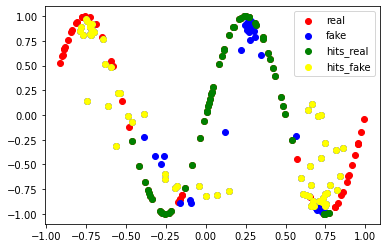

9999 0.62 0.51


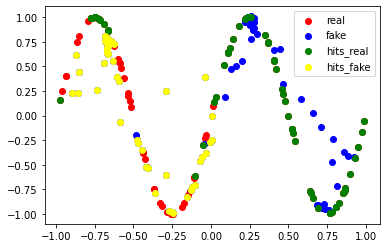

KeyboardInterrupt: 

In [142]:
train(generator=generator,
      discriminator=discriminator,
      gan_model=gan_model,
      latent_dim=n_latent_variables,
      n_epochs=20000,
      n_eval=5000,
      n_batch=128)

In [ ]:
print('done')

In [ ]:
for n, p in generator.named_parameters():
    print(n, p.shape)